In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:22pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:22pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:22pt;padding:5px;}
table.dataframe{font-size:22px;}
</style>
"""))

In [13]:
# ============================================================
# [단락 0] 라이브러리
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ============================================================
# [단락 1] 데이터 로드
# ============================================================
path = r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리_폐업률머지.csv"
df = pd.read_csv(path, low_memory=False)

print(df.shape)
print(df[["구","업태_그룹","폐업률_3년이내_pct"]].head())

(241267, 24)
     구   업태_그룹  폐업률_3년이내_pct
0  은평구      기타          31.0
1  은평구      한식          33.2
2  서초구  분식/간편식          39.7
3  서초구   양식/외식          30.0
4   중구   주점/치킨          24.5


In [4]:
# ============================================================
# [단락 2] (구, 업태_그룹) 유니크 데이터셋 만들기
#  - 조합당 폐업률이 하나로 고정이므로 조합당 1개 행만 사용
# ============================================================
g = (
    df[["구", "업태_그룹", "폐업률_3년이내_pct"]]
      .dropna()
      .groupby(["구", "업태_그룹"], as_index=False)
      .agg({"폐업률_3년이내_pct": "first"})
)

y = g["폐업률_3년이내_pct"].astype("float32").values

print("유니크 조합 수:", len(g))
print(g.head())


유니크 조합 수: 175
     구   업태_그룹  폐업률_3년이내_pct
0  강남구      기타          38.3
1  강남구  분식/간편식          34.0
2  강남구   양식/외식          30.3
3  강남구   주점/치킨          33.3
4  강남구    중/일식          28.1


In [5]:
# ============================================================
# [단락 3] 원-핫 인코딩
# ============================================================
X_df = pd.get_dummies(g[["구", "업태_그룹"]].astype(str), drop_first=False)
X = X_df.astype("float32").values

print("X shape:", X.shape)
print("원핫 컬럼 수:", X_df.shape[1])


X shape: (175, 32)
원핫 컬럼 수: 32


In [6]:
# ============================================================
# [단락 4] Train / Val / Test split
# ============================================================
idx = np.arange(len(g))
tr, te = train_test_split(idx, test_size=0.2, random_state=42)
tr, va = train_test_split(tr, test_size=0.2, random_state=42)

X_tr, X_va, X_te = X[tr], X[va], X[te]
y_tr, y_va, y_te = y[tr], y[va], y[te]

print("train/val/test:", X_tr.shape, X_va.shape, X_te.shape)


train/val/test: (112, 32) (28, 32) (35, 32)


In [7]:
# ============================================================
# [단락 5] 모델 정의(회귀)
# ============================================================
inp = keras.Input(shape=(X.shape[1],), name="onehot")
x = layers.Dense(64, activation="relu")(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(1, activation="linear")(x)

model = keras.Model(inp, out)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.MAE]
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onehot (InputLayer)         [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [8]:
# ============================================================
# [단락 6] 학습
# ============================================================
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
4/4 [==============================] - 0s 48ms/step - loss: 1018.8570 - mean_absolute_error: 31.4269 - val_loss: 977.7103 - val_mean_absolute_error: 30.7765
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 1011.2563 - mean_absolute_error: 31.3049 - val_loss: 969.9448 - val_mean_absolute_error: 30.6511
Epoch 3/300
4/4 [==============================] - 0s 5ms/step - loss: 1003.0639 - mean_absolute_error: 31.1722 - val_loss: 962.0903 - val_mean_absolute_error: 30.5236
Epoch 4/300
4/4 [==============================] - 0s 8ms/step - loss: 995.3002 - mean_absolute_error: 31.0466 - val_loss: 954.0208 - val_mean_absolute_error: 30.3919
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 986.3771 - mean_absolute_error: 30.9008 - val_loss: 945.4435 - val_mean_absolute_error: 30.2512
Epoch 6/300
4/4 [==============================] - 0s 11ms/step - loss: 978.1063 - mean_absolute_error: 30.7645 - val_loss: 936.3775 - val_mean_absolute_error: 

4/4 [==============================] - 0s 9ms/step - loss: 23.5415 - mean_absolute_error: 3.7464 - val_loss: 23.5384 - val_mean_absolute_error: 3.6687
Epoch 51/300
4/4 [==============================] - 0s 6ms/step - loss: 22.6378 - mean_absolute_error: 3.7185 - val_loss: 22.9290 - val_mean_absolute_error: 3.6315
Epoch 52/300
4/4 [==============================] - 0s 7ms/step - loss: 26.0097 - mean_absolute_error: 3.8336 - val_loss: 22.2759 - val_mean_absolute_error: 3.6016
Epoch 53/300
4/4 [==============================] - 0s 11ms/step - loss: 23.5384 - mean_absolute_error: 3.6080 - val_loss: 21.6424 - val_mean_absolute_error: 3.5744
Epoch 54/300
4/4 [==============================] - 0s 9ms/step - loss: 23.4140 - mean_absolute_error: 3.8443 - val_loss: 21.0859 - val_mean_absolute_error: 3.5562
Epoch 55/300
4/4 [==============================] - 0s 6ms/step - loss: 22.6036 - mean_absolute_error: 3.7573 - val_loss: 20.5695 - val_mean_absolute_error: 3.5467
Epoch 56/300
4/4 [==========

Epoch 100/300
4/4 [==============================] - 0s 4ms/step - loss: 11.8972 - mean_absolute_error: 2.7013 - val_loss: 13.2205 - val_mean_absolute_error: 3.1287
Epoch 101/300
4/4 [==============================] - 0s 6ms/step - loss: 11.8076 - mean_absolute_error: 2.6524 - val_loss: 13.1693 - val_mean_absolute_error: 3.1273
Epoch 102/300
4/4 [==============================] - 0s 12ms/step - loss: 11.5206 - mean_absolute_error: 2.6106 - val_loss: 13.1515 - val_mean_absolute_error: 3.1271
Epoch 103/300
4/4 [==============================] - 0s 3ms/step - loss: 12.7892 - mean_absolute_error: 2.7515 - val_loss: 13.1667 - val_mean_absolute_error: 3.1279
Epoch 104/300
4/4 [==============================] - 0s 8ms/step - loss: 11.7997 - mean_absolute_error: 2.7800 - val_loss: 13.1779 - val_mean_absolute_error: 3.1275
Epoch 105/300
4/4 [==============================] - 0s 10ms/step - loss: 11.1151 - mean_absolute_error: 2.6277 - val_loss: 13.2231 - val_mean_absolute_error: 3.1327
Epoch 10

In [9]:
# ============================================================
# [단락 7] 평가 + 예측 출력
# ============================================================
res = model.evaluate(X_te, y_te, verbose=0)
print("\n[Test] MSE, MAE =", res)

pred = model.predict(X_te, verbose=0).reshape(-1)

print("\n예측 vs 실제 (10개)")
for p, t in list(zip(pred[:10], y_te[:10])):
    print(f"pred={p:.1f}%  true={t:.1f}%")



[Test] MSE, MAE = [11.272109031677246, 2.7108333110809326]

예측 vs 실제 (10개)
pred=20.3%  true=23.2%
pred=22.9%  true=24.6%
pred=26.8%  true=28.6%
pred=43.5%  true=48.0%
pred=32.7%  true=30.6%
pred=30.7%  true=27.9%
pred=36.7%  true=37.2%
pred=38.2%  true=45.6%
pred=37.0%  true=37.3%
pred=32.6%  true=36.5%


In [10]:
# ============================================================
# [단락 7] 검증(Val) 예측 + 결과 출력 (소수 1자리 "표시" 강제)
# ============================================================
pred_va = model.predict(X_va, verbose=0).reshape(-1)

mae_va = float(np.mean(np.abs(pred_va - y_va)))
mse_va = float(np.mean((pred_va - y_va) ** 2))
rmse_va = float(np.sqrt(mse_va))

print(f"\n[Validation] MAE = {mae_va:.1f} | RMSE = {rmse_va:.1f} | MSE = {mse_va:.1f}")

val_result = g.iloc[va][["구", "업태_그룹"]].copy()
val_result["true_pct"] = y_va
val_result["pred_pct"] = pred_va
val_result["abs_error"] = np.abs(val_result["pred_pct"] - val_result["true_pct"])

# ✅ 출력용 포맷(문자열) 컬럼 생성: 소수 1자리로 "강제 표시"
val_result["true_pct"]  = val_result["true_pct"].map(lambda x: f"{x:.1f}")
val_result["pred_pct"]  = val_result["pred_pct"].map(lambda x: f"{x:.1f}")
val_result["abs_error"] = val_result["abs_error"].map(lambda x: f"{x:.1f}")

print("\n[검증 예측 결과]")
print(val_result.to_string(index=False))

print("\n[오차 큰 순]")
print(val_result.sort_values("abs_error", ascending=False).to_string(index=False))



[Validation] MAE = 3.1 | RMSE = 3.6 | MSE = 12.7

[검증 예측 결과]
   구  업태_그룹 true_pct pred_pct abs_error
 도봉구     기타     32.1     34.9       2.8
 관악구     카페     31.7     30.7       1.0
 동작구     카페     29.6     26.5       3.1
 양천구  주점/치킨     34.1     34.1       0.0
 송파구     카페     33.1     29.3       3.8
동대문구     카페     24.6     30.3       5.7
 금천구     기타     32.5     34.7       2.2
영등포구  주점/치킨     31.1     29.0       2.1
 은평구     한식     33.2     32.7       0.5
 금천구     카페     25.7     31.0       5.3
 노원구  양식/외식     29.7     31.5       1.8
 서초구  양식/외식     30.0     28.6       1.4
동대문구  주점/치킨     29.9     31.1       1.2
 광진구 분식/간편식     43.3     37.4       5.9
 송파구  양식/외식     35.0     31.3       3.7
 종로구  주점/치킨     24.3     19.3       5.0
 종로구     카페     19.9     18.9       1.0
서대문구     한식     27.8     31.1       3.3
 서초구     카페     31.2     26.3       4.9
 성동구  양식/외식     27.4     30.1       2.7
  중구     카페     24.0     27.1       3.1
 중랑구 분식/간편식     45.1     39.4       5.7
 은평구     기타     31

In [11]:
# ============================================================
# [단락 8] 검증/테스트 예측값 생성
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

pred_va = model.predict(X_va, verbose=0).reshape(-1)
pred_te = model.predict(X_te, verbose=0).reshape(-1)

# (선택) %값이라 0~100 범위로 클리핑(튀는 값 방지)
pred_va = np.clip(pred_va, 0, 100)
pred_te = np.clip(pred_te, 0, 100)


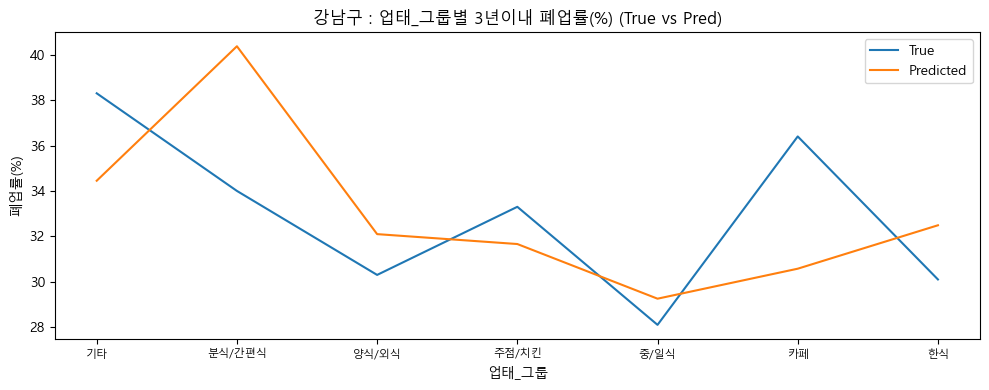

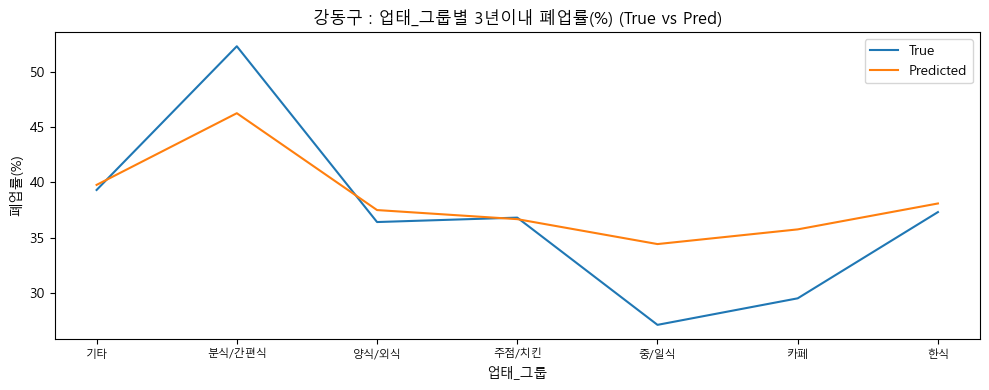

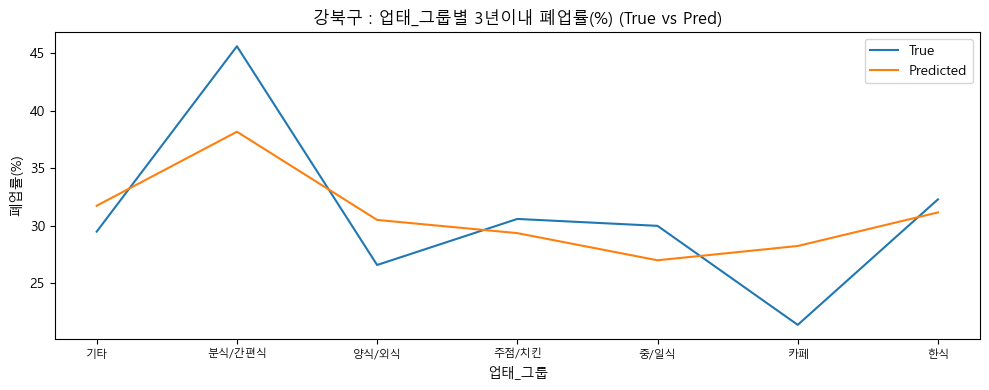

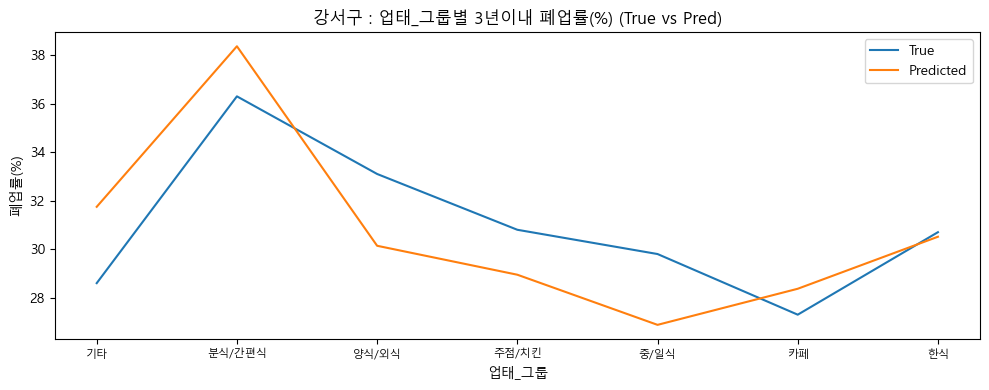

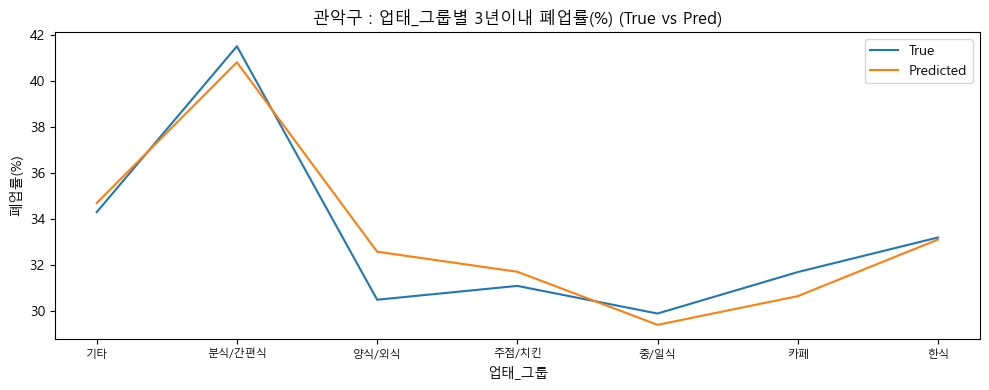

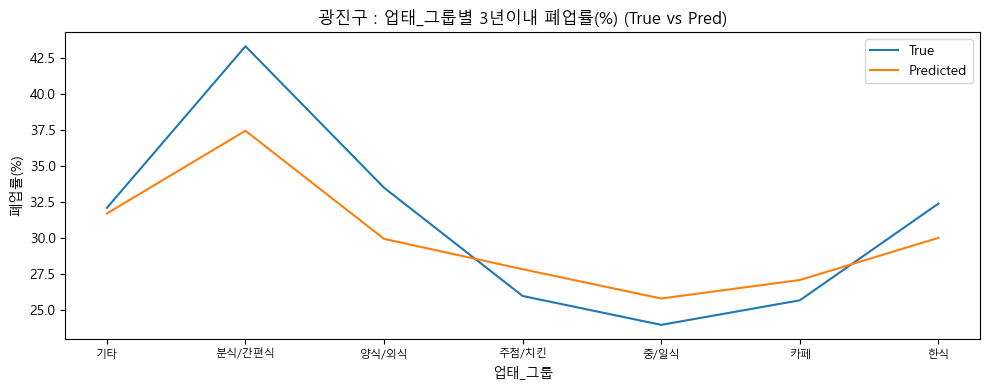

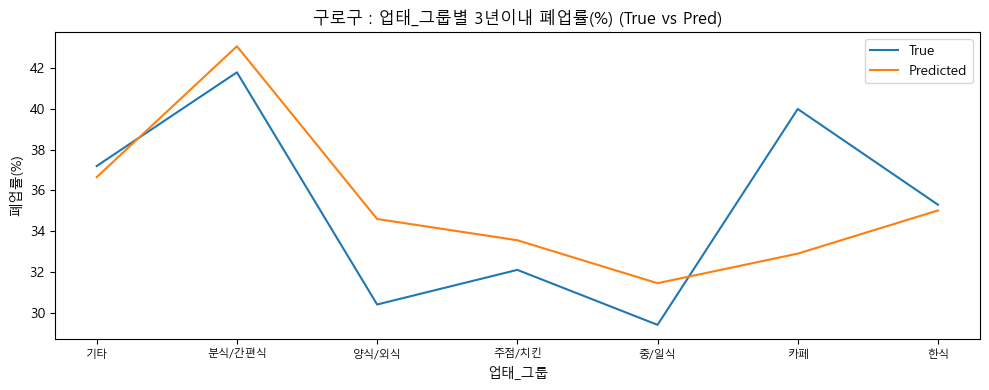

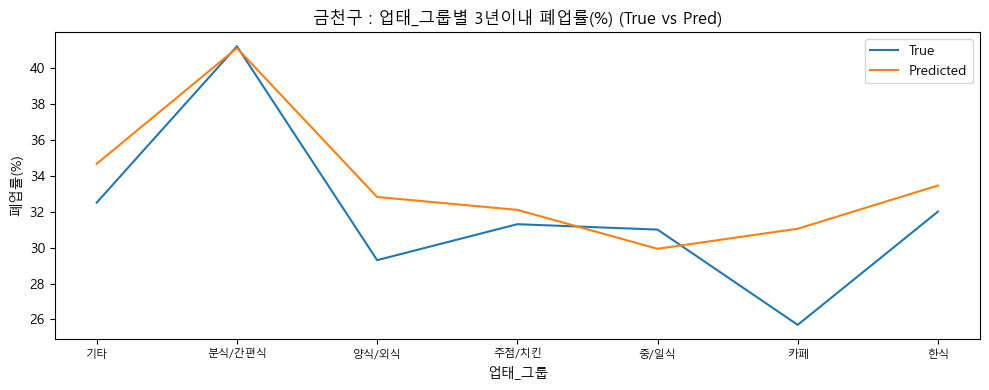

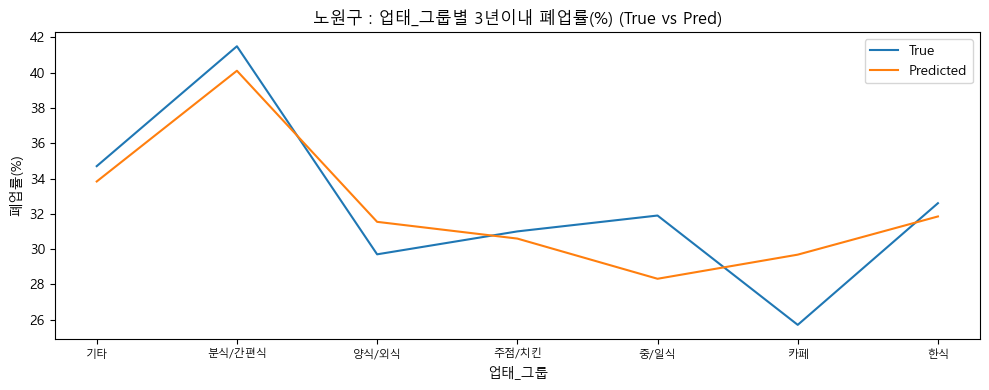

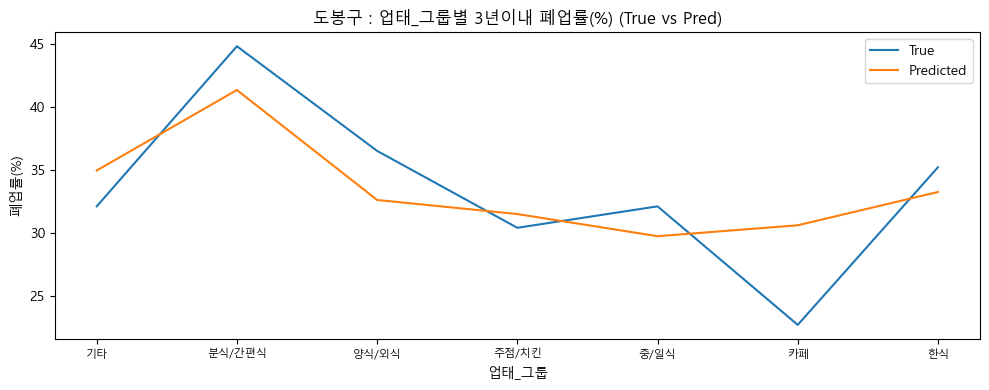

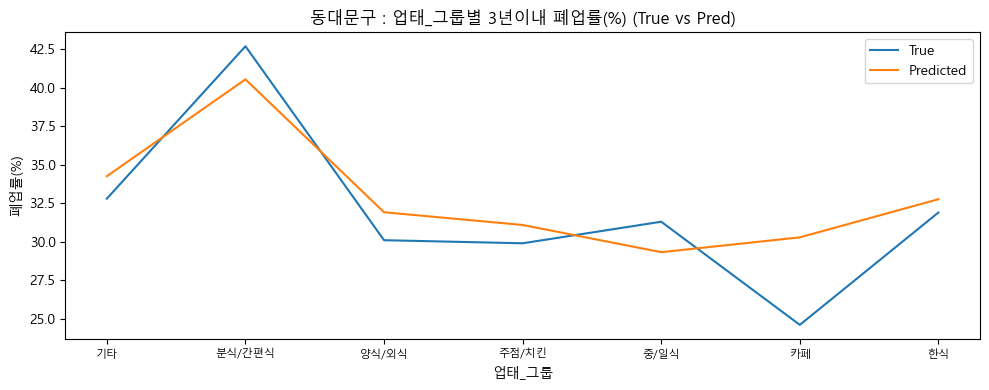

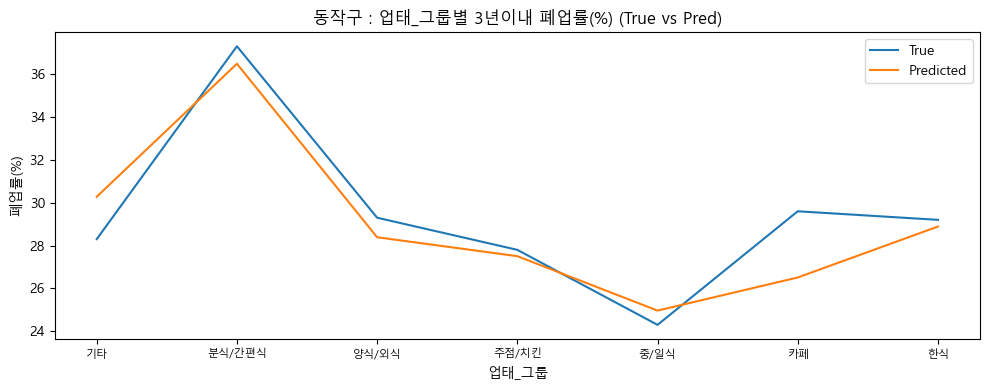

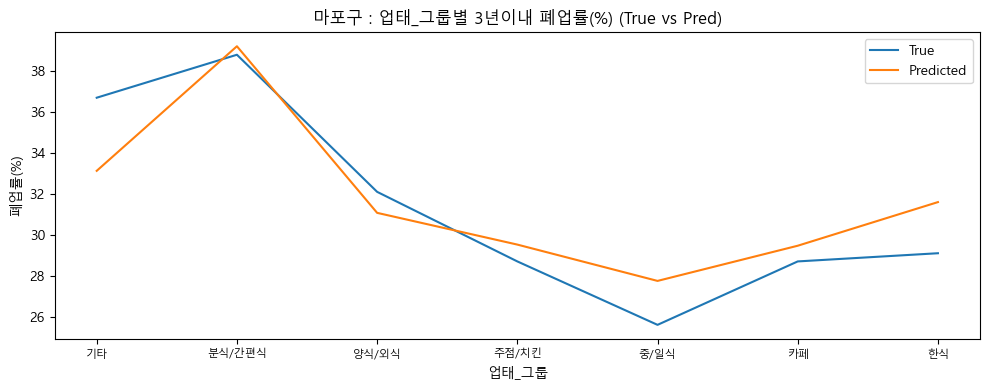

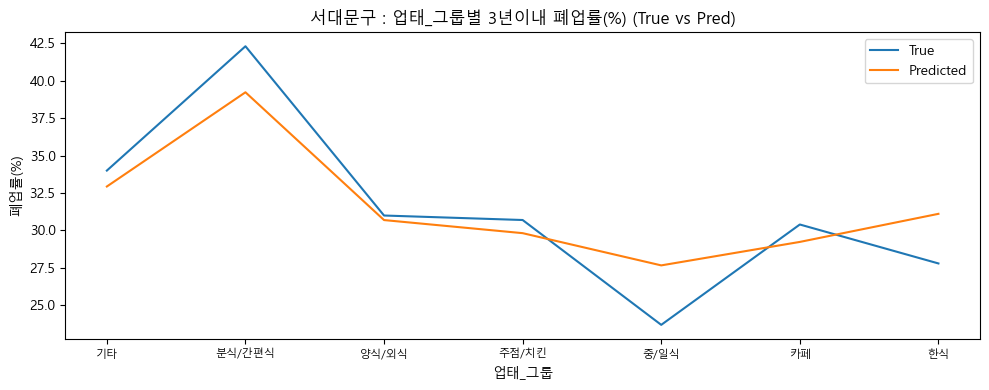

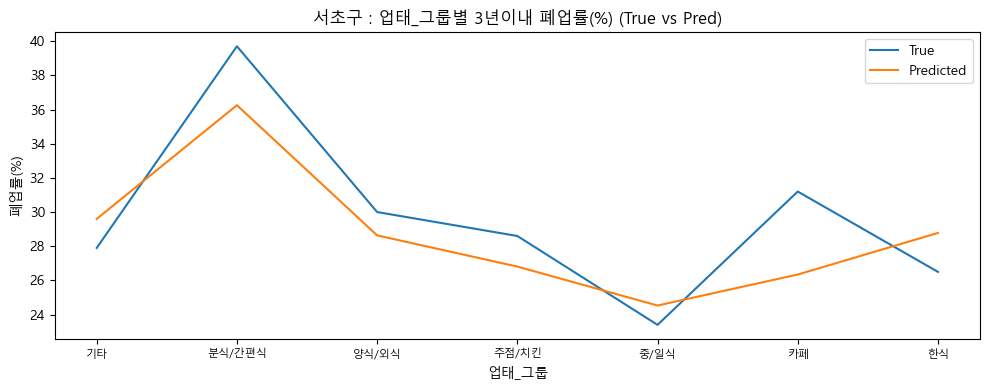

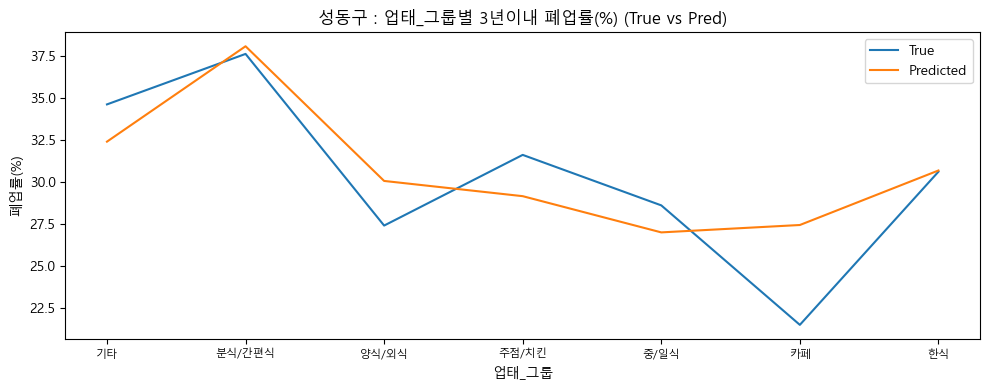

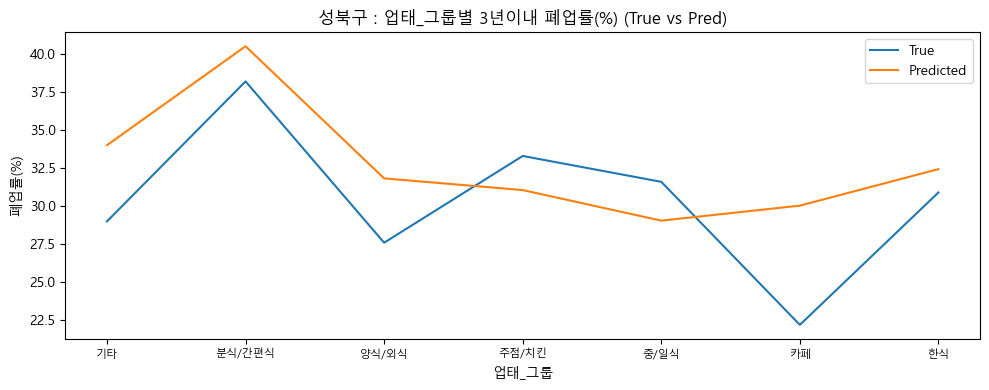

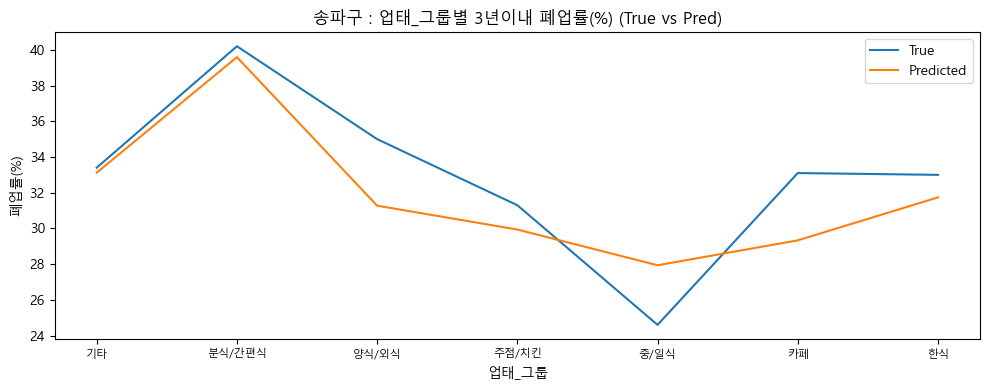

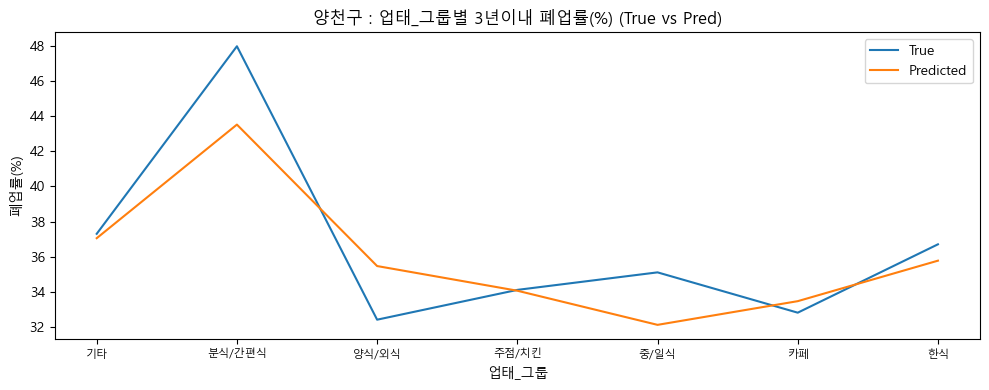

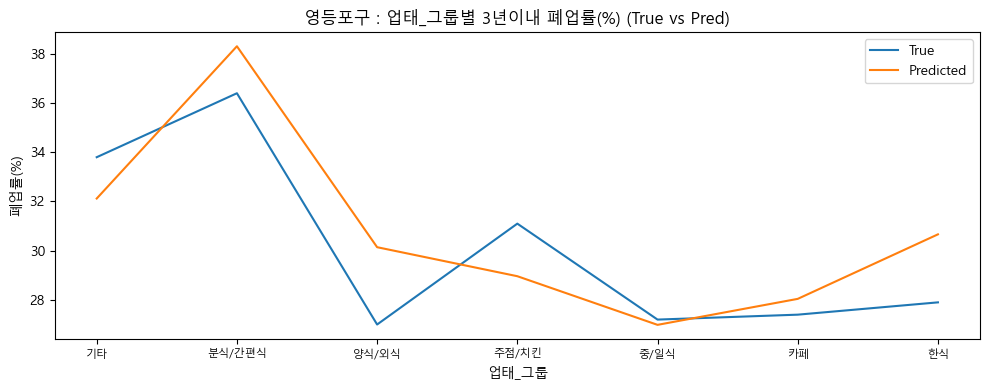

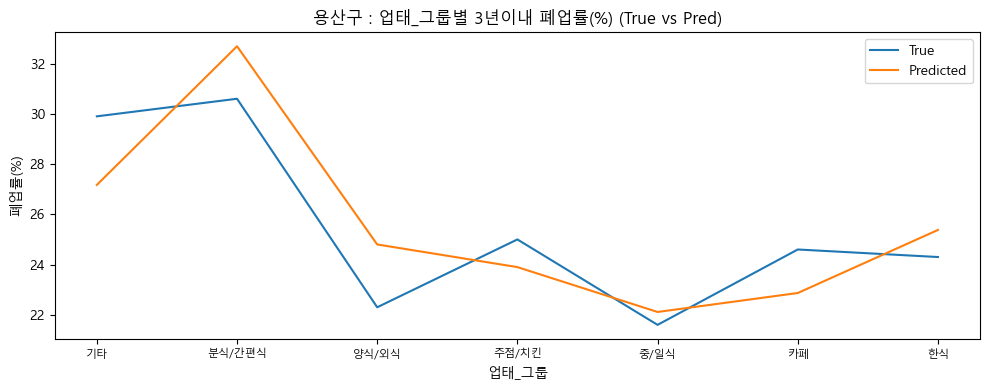

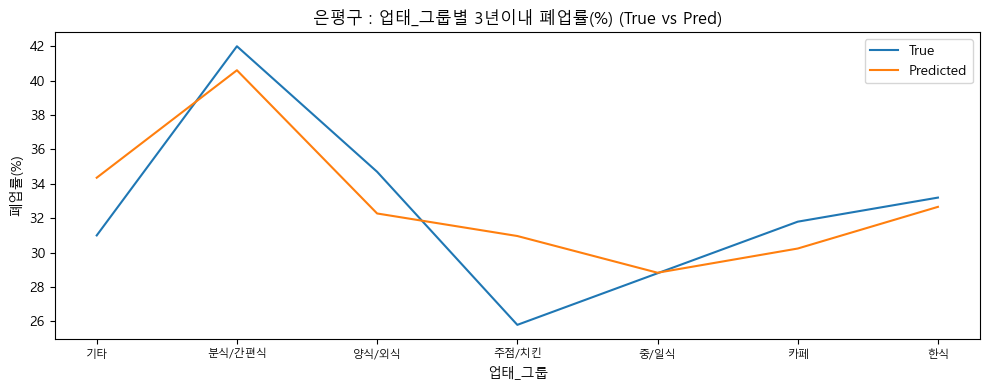

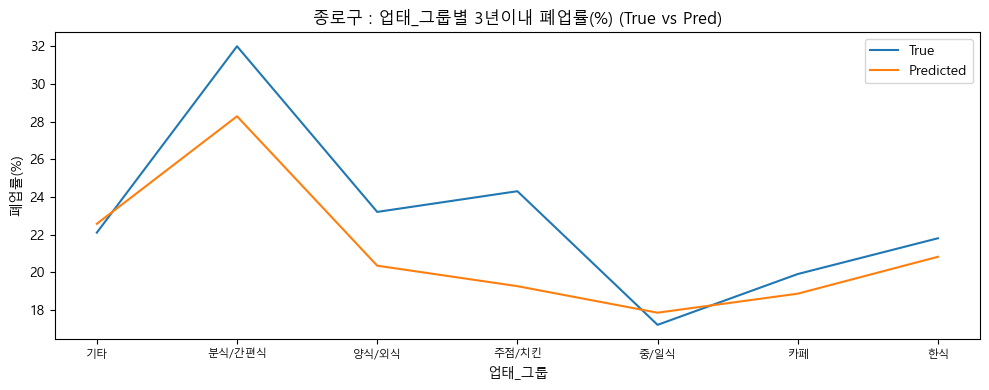

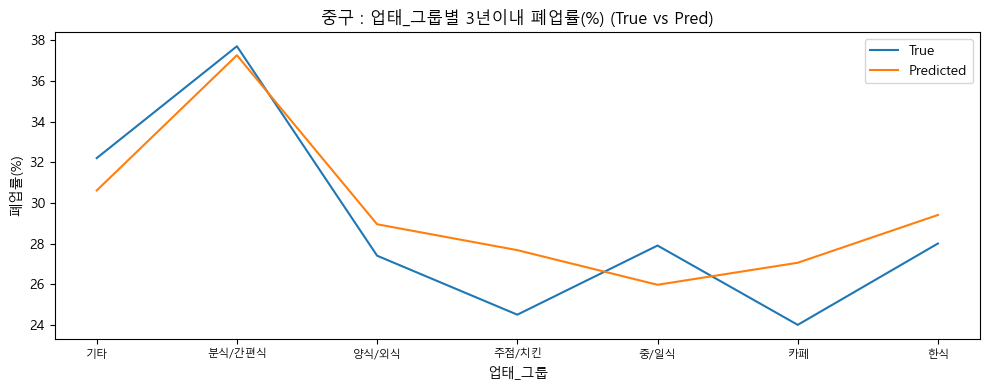

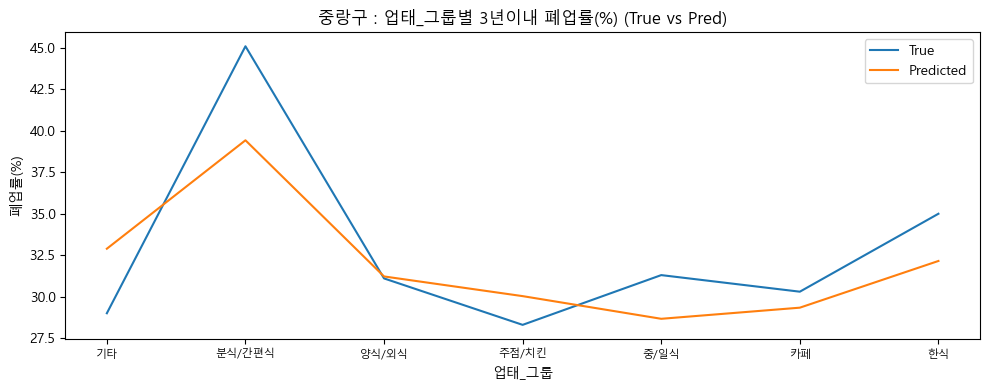

In [14]:
# ============================================================
# [단락 9] 구별 라인그래프: True(실제) vs Pred(예측) — 다른 색으로 표시
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

tmp = g.copy()
tmp["pred_pct"] = np.clip(model.predict(X, verbose=0).reshape(-1), 0, 100)

gus = sorted(tmp["구"].dropna().unique())

for gu in gus:
    d = tmp[tmp["구"] == gu].copy()
    d = d.sort_values("업태_그룹").reset_index(drop=True)

    labels = d["업태_그룹"].astype(str).tolist()
    true_v = d["폐업률_3년이내_pct"].astype(float).values
    pred_v = d["pred_pct"].astype(float).values
    x = np.arange(len(d))

    fig_w = max(10, len(d) * 0.7)

    plt.figure(figsize=(fig_w, 4))
    plt.plot(x, true_v, label="True", color="tab:blue")
    plt.plot(x, pred_v, label="Predicted", color="tab:orange")

    plt.title(f"{gu} : 업태_그룹별 3년이내 폐업률(%) (True vs Pred)")
    plt.xlabel("업태_그룹")
    plt.ylabel("폐업률(%)")
    plt.xticks(x, labels, rotation=0, fontsize=8)  # 가로

    plt.legend()
    plt.tight_layout()
    plt.show()
